# JOINs and UNIONs

**1. Introduction**

In the intro to SQL micro-course, you learned how to use INNER JOIN to consolidate information from two different tables. Now you'll learn about a few more types of JOIN, along with how to use UNIONs to pull information from multiple tables.

Along the way, we'll work with two imaginary tables, called owners and pets.

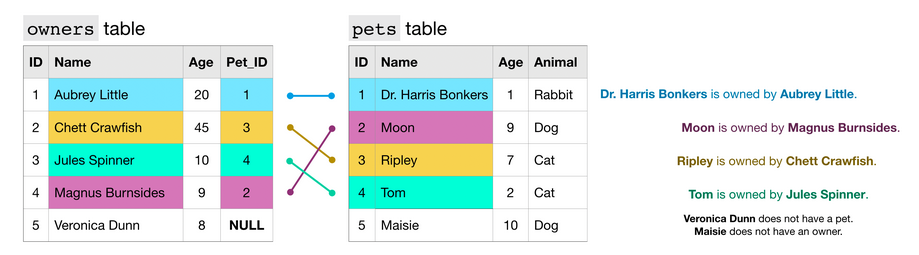

Each row of the owner table identifies a pet owner, where the ID column is a unique identifier. The Pet_ID column (in the owners table) conatains the ID for the pet that belongs to the owner (this number matches the ID for the pet from the pets table).

For example, 

- the pets table shows that Dr.Harris Bonker is the pet with ID 1.
- The owner table shows that Aubery Little is the owner of the pet with ID1. 

Putting these two facts togheter, Dr.Harris Bonkers is owneb by Aubery Little. Likewise, since Veronica Dunn does not have a corresponding Pet_ID, she does not have a pet. And, since 5 does not appear in the Pet_ID column, Maisie does not have an owner. 


**2. JOINs**

Recall that we an use an INNER JOIN to pull rows from both tables where the value in the PET_ID column in the owners table has a match in the ID column of the pets table. 

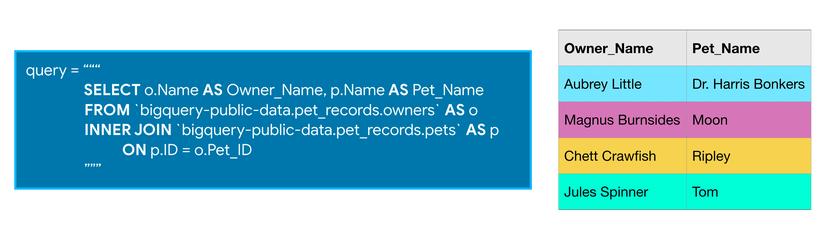

In this case, Veronica Dunn and Maisie are not included in the results. But what if we instead want to create a table containing all pets, regardless of whether they have owner? Or, what if we want to combine all of the rows in both tables? In these cases, we need only use a different type of JOIN.

For instance, to create a table containing all rows from the owners table, we usea LEFT JOIN. In this case, "left" refers to the table that appears before the JOIN in the query. ("Right" refers to the table that is after the JOIN.)

Replacing INNER JOIN in the uqery above with LEFT JOIN returns all rows where the two tables matching entries, along with all of the rows in the left table (whether there is a match or not). 

If we instead use a RIGHT JOIN, we get the matching rows, along with all rows in the right table (whether there is a match or not).

Finally a FULL JOIN returns all rows from both tables. Note that in general, any row that does not have a match in both tables will have NULL entries for the missing values. You can see this in the image below. 

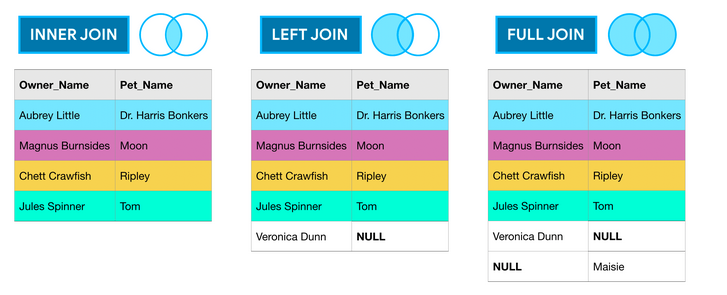


**3. UNIONS**

As you've seen, JOINs horizontally combines results from different tables. If you instead would like to vertically concatenate columns, you can do so with a UNION. The example query below combines the Age columns from both tables. 

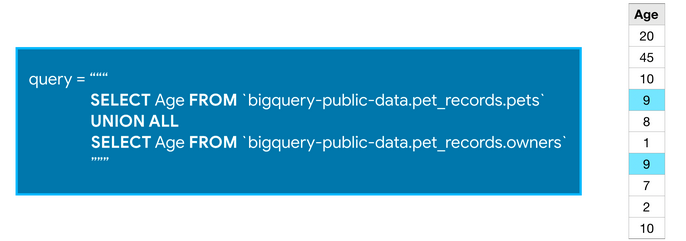

Note that with a UNION, the data types of both columns must be the same, but the columns names can be different. (So, for instance, we cannot take the UNION of the ge column from the owners table and the Pet_Name column from the pets table.)

We use UNION ALL to include duplicated values - you'll notice that 9 appeas in both the owners table and the pets table, and shows up twice in the concatenated results. If you'd like to drop duplicate values, you need only change UNION ALL in the query to UNION DISTINCT.

In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

# Construct a reference to the "stories" table

table_ref = dataset_ref.table("stories")

# API - request - fetch the table

table = client.get_table(table_ref)

# Preview the first five lines of the table

client.list_rows(table, max_results=5).to_dataframe()

In [1]:
# Query to select all stories posted on January 1, 2012, with number of comments

job_query = """
            WITH c AS
            (
            SELECT parent, COUNT(*) AS num_comments
            FROM `bigquery-public-data.hacker_news.comments`
            GROUP BY parent
            )
            SELECT s.id AS story_id, s.by, s.title, c.num_comments
            FROM `bigquery-public-data.hacker_news.stories` AS s 
            LEFT JOIN c
            ON s.id = c.parent
            WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-01'
            ORDER BY c.num_comments DESC
            """

# Run the query, and return a pandas DataFrame

join_result = client.query(job_query).result().to_dataframe()

# Analytic Functions

**1. Introduction**

In the intro to SQL micro-course, you learned how to use aggregate functions, which perform calculations based on sets of rows. In this tutorial, you'll learn how to define analytic functions, which also operate on a set of rows. However, unlike aggregate functions, analytic functions return a (potentially different) value for each row in the original table.

Analytic functions allow us to perform complex calculations with relatively straightfoward syntax. For instance, we can quickly calculate moving averages and running totals, among other quantities.


**2. Syntax**

To understand how to write analytic functions, we'll work with a small  table containing data from two different people who are training for a race. The id column identifies each runner, the date column holds the day of the training session, and time shows the time (in minutes) that the runner dedicated to training. Say we'd like to calculate a moving agerage of the training times for each runner, where we always take the average of the current and previous training sessions. 

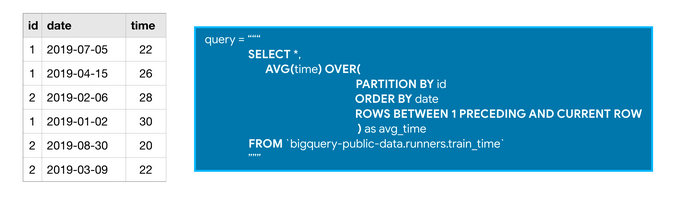

All analytic functions have an 'OVER' clause, which defines the sets of rows used in each calculation. The 'OVER' cluase has three (optional) part :

- The PARTIION BY cluase divides the rows of table into different groups. In the query above, we divide by id so that the calculation are separated by runner.
- The ORDER BY cluase defines an ordering within each partition. In the sample query, ordering by the data column ensures that earlier training sessions appear first.
- The final cluase ( ROWS BETWEEN 1 PREDCIDING AND CURRENT ROW ) is known as a window frame cluase. It identifies the set of rows used in each calculation. We can refer to this group of rows as a window. 

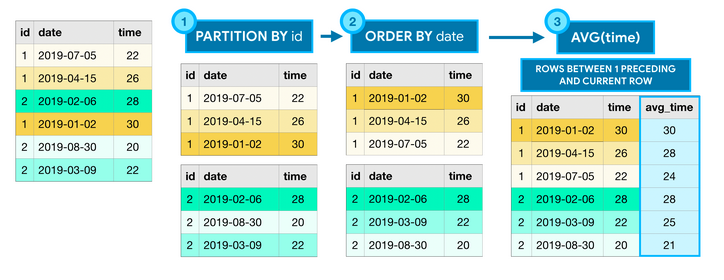

**3. (More on) window frame cluase**

There are many ways to write window frame cluases : 
- ROWS BETWEEN 1 PRECEDING AND CURRENT ROW : the previous row and the current row.
- ROWS BETWEEN 3 PRECIDING AND 1 FOLLOWING : the 3 previous rows, the current row, the following row.
- ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING : all rows in the partition

Of course, this is not an exhaustive list, and you can imagine that there are many more options! 

**4. Three types of analytic functions**

The example above uses only one of many analytic functions. BigQuery supports a wide variety of analytic functions, and we'll explore a few here.

1) Analytic aggregate functions  
As you might recall, AVG() (from the example above) is an aggregate function. The OVER cluase is what ensures that it's treated as an analytic (aggregate) function. Aggregate functions take all of the values within the window as input and return a single value. 

- MIN() or MAX() : returns the minimum of input values
- AVG() or SUM() : returns the average of input values
- COUNT() : returns the number of rows in the input

2) Analytic navigation functions  
Navigation functions assign a value based on the value in a different row than the current row. 
- FIRST_VALUE() or LAST_VALUE() : returns the first/last value in the input
- LEAD() or LAG() : returns the value on a subsequent/preceding row 

3) Analytic numbering functions  
Numbering functions assign integer values to each row based on the ordering.
- ROW_NUMBER() : returns the order in which rows appear in the input
- RANK() : all rows with the same value in the ordering column receive the same rank value, where the next row receives a rank value which increments by the number of rows with the previous rank value.

In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "san_francisco" dataset
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "bikeshare_trips" table
table_ref = dataset_ref.table("bikeshare_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe() 

In [ ]:
# Calculate the cumulative number of trips for each date in 2015.

num_trips_query = """
                  WITH trip_by_day AS
                      (
                      SELECT DATE(start_date) AS trip_date, 
                          COUNT(*) as num_trips
                      FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                      WHERE EXTRACT(YEAR FROM start_date) = 2015
                      GROUP BY trip_date
                      )
                      SELECT *, 
                          SUM(num_trips)
                              OVER (
                                   ORDER BY trip_date
                                   ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                                   ) AS cumulative_trips
                          FROM trip_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

The query uses a common table expression (CTE) to first calculate the daily number of trips. Then, we use SUM() as an aggregate function. 

- Since there is no PARTITION BY clause, the entire table is treated as a single partition.
- The ORDER BY cluase orders the rows by date, where earlier dates appear first
- By setting the window frame cluase to ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW, we ensure that all rows up to and including the vurrent date are used to calculate the (cumulative) sum. 

In [ ]:
# Tracks the stations where each bike began and ended the day on October 25, 2015.

# Query to track beginning and ending stations on October 25, 2015, for each bike
start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) AS trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE DATE(start_date) = '2015-10-25' 
                  """

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()



The query uses both FIRST_VALUE() and LAST_VALUE() as analytic functions.
- The PARTITION BY cluase breaks the data into partitions based on the bike_number coumns. Since this column holds unique identifiers for bikes, this ensures the calculation are performed separately for each bike.
- The ORDER BY cluase puts the rows within each partition in chronological order.
- Since the window frame clause is ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING, for each row, its entire partition is used to perform the calculation.

# Nested and Repeated Data

**1. Introduction**

So far, you've worked with many types of data, including numeric types, strings, and the DATETIME type. In this tutorial, you'll learn how to query nested and repeated data. These are the most complex data types that you can find in BigQuery datasets!

**2. Nested data**

Consider a hypothetical dataset containing information about pets and their toys. We could organize this information in two different tables(a pets and a toys table). The toys table could contains a "Pet_ID" column that could be used to match each toy to the pet that owns it. 

Another option in BigQuery is to organize all the information in a single table, similar to the 'pets_and_toys' table below.

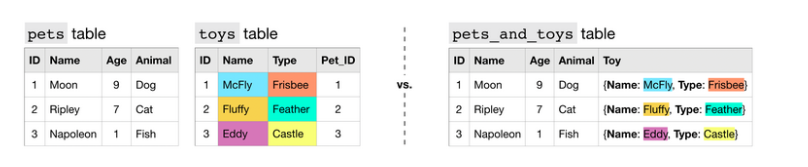

In this case, all of the information from the 'toys' table is collapsed into a single column (the "Toy" column in the 'pets_and_toys' table). We refer to the "Toy" column in the 'pets_and_toys' table as a nested column, and say that the "Name" and "Type" fields are nested inside of it.

Nested columns have type STRUCT (or type RECORD). This is reflected in the table schema below. 

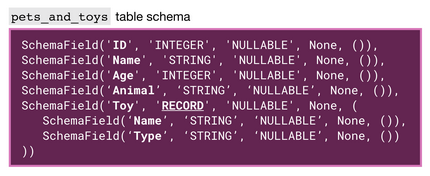

To query a column with nested data, we need to identify each field in the context of the column that contains it :

- Toy.Name refers to the "Name" field in the "Toy" column
- Toy.Type refers to the "Type" field in the "Toy" column

Otherwise, our unusual rules remain the same - we need not change anything else about our queries. 

**3. Repeated data**

Now consider the (more realistic) case where each pet can have mutliple toys. In this case, to collapse this information into a single table, we need to leverage a different datatype.

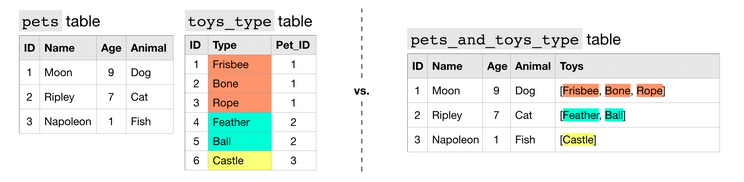

We say that the "Toys" column contains repeated data, because it permits more than one value for each row. This is reflected in the table schema below, where the mode of the "Toys" column appears as 'REPEATED'. 

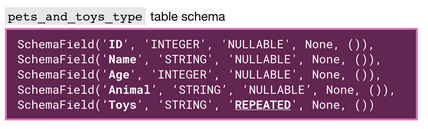

Each entry in a repeated field is an ARRAY, or an ordered list of (zero or more) values with the same datatype. For instance, the entry in the "Toys" column for Moon the Dog is [Frisbee, Bone, Rope], which is an ARRAY with three values. 

When querying repeated data, we need to put the name of the column containing the repeated data inside an UNSET() function.

In [ ]:
query = """
        SELECT Name AS Pet_Name, Toy_Type
        FROM `bigquery-public-data.pet_records.pets_and_toys_type`,
            UNNEST(Toys) AS Toy_Type
        """

This is essential flatten the repeated data (which is then appended to the right side of the table) so that we have one element on each row.

In [ ]:
query = """
        SELECT *
        FROM `bigquery-public-data.pet_records.pets_and_toys_type`,
            UNNEST(Toys) AS Toy_Type
        """

**4. Nested and repeated data**

Now, when if pets can have multiple toys, and we'd like to keep track of both the name and type of each toy? In this case, we make the "Toys" column both nested and repeated.

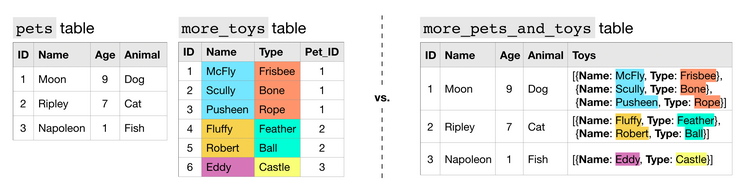

In the 'more_pets_and_toys' table above, "Name" and "Type" are both field contained within the "Toys" STRUCT, nad each entry in both "Toys.Name" and "Toys.Type" is an ARRAY.

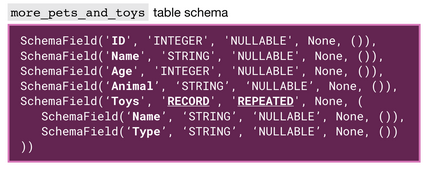

In [ ]:
query = """
        SELECT Name AS Pet_Name,
               t.Name AS Toy_Name, 
               t.Type AS Toy_Type
        FROM `bigquery-public-data.pet_records.more_pets_and_toys`,
            UNNSET(Toys) AS t
        """

Since the "Toys" column is repeated, we faltten it with the UNNSET() function. And, since we give the flattened column an alias of t, we can refer to the "Name" and "Type" fields in the "Toys" column as t.Name and t.Type, respectively.

- UNNEST는 데이터를 먼저 풀어 각각의 컬럼으로 풀어낸다 

| schema1 | schema2 | 
| --- | --- | 
| val11 | val21 | 
| | val22 | 
| val12 | val23 | 
| | val24 | 
| | val25 | 

| schema1 | schema2 | 
| --- | --- | 
| val11 | val21 | 
| val11 | val22 | 
| val12 | val23 | 
| val12 | val24 | 
| val13 | val25 | 

- 그냥 Nested된 데이터는 바로 RECORD type에서 dot 연산자를 통해 추출하면 됨
- 단 Nested + Repeated된 데이터는 RECORD type과 REPEATED type이 모두 존재하는 경우, UNNEST() 를 적용한 후 dot 연산자를 통해 추출한다 

# Writing Efficient Queries

**1. Introduction**

Sometimes it doesn't matter whether your query is efficient or not. For example, you might write a query you expect to run only once, and it might be working on a small dataset. In this case, anything that gives you the answer you need will do.

But what about queries that will be run many times, like a query that feeds data to a website? Those need to be efficient so you don't leave users waiting for your website to load.

Or what about queries on huge datasets? These can be slow and cost a business a lot of money if they are written poorly.

Most database systems have a query optimizer that attempts to interpret/execute your query in the most effective way possible. But several strategies can still yield huge savings in many cases.

**2. Some useful functions**

- show_amount_of_data_scanned() shows the amount of data the query uses
- show_time_to_run() prints how long it takes for the query to execute

In [ ]:
from google.cloud import bigquery
from time import time

client = bigquery.Client()

def show_amount_of_data_scanned(query):
    # dry_run lets us see how much data the query uses without running it
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))

**3. Strategies**

1. Only select the columns you want

It is tempting to start queries with SELECT * FROM ... it's convinient because you don't need to think about which columns you need. But it can be very inefficient.

This ise especially important if there are text fields that you don't need, because text field tend to be larger than other fields.

In [ ]:
star_query = "SELECT * FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(star_query)

basic_query = "SELECT size, binary FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(basic_query)

In this case, we see a 1000X reduction in data being scanned to complete the query, because the raw data contained a text field that was 1000X larger than the fields we might need.

2. Read less data

Both queries below calculate the average duration (in seconds) of one-way bike trips in the city of San Francisco.

In [ ]:
more_data_query = """
                  SELECT MIN(start_station_name) AS start_station_name,
                      MIN(end_station_name) AS end_station_name,
                      AVG(duration_sec) AS avg_duration_sec
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_id != end_station_id 
                  GROUP BY start_station_id, end_station_id
                  LIMIT 10
                  """
show_amount_of_data_scanned(more_data_query)

less_data_query = """
                  SELECT start_station_name,
                      end_station_name,
                      AVG(duration_sec) AS avg_duration_sec                  
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_name != end_station_name
                  GROUP BY start_station_name, end_station_name
                  LIMIT 10
                  """
show_amount_of_data_scanned(less_data_query)

Since ther is a 1:1 relationship between the station ID and the station name, we don't need to use the 'start_station_id' and 'end_station_id' columns in the query. By using only the columns with the station IDs, we can less data.

3. Avoid N:N JOINs 

Most of JOINs that we have executed in the course have been 1:1 JOINs. 

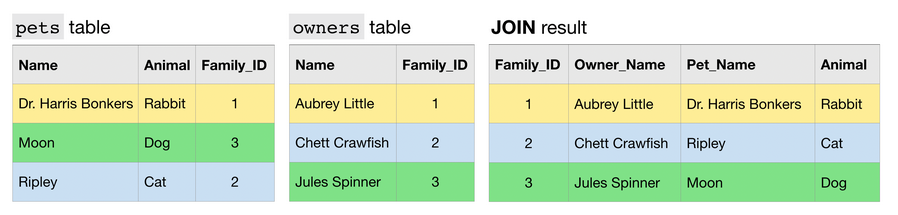

Another type of JOIN is an N:1 JOIN. Here, each row in one table matches potentially many rows in the other table.

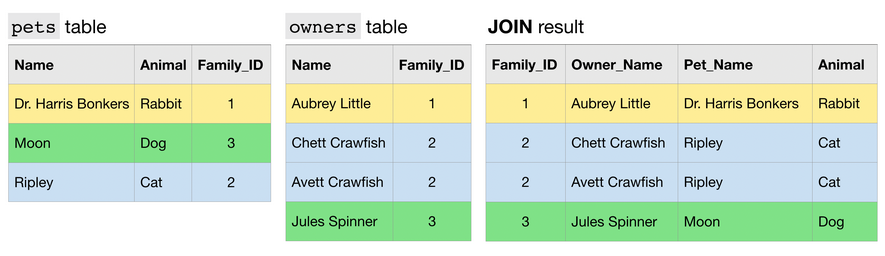

Finally, an N:N JOIN is one where a group of rows in one table can match a group of rows in the other table. Note that in general, all other things equal, this type of JOIN produces a table with many rows than either of the two tables that are being JOINed. 

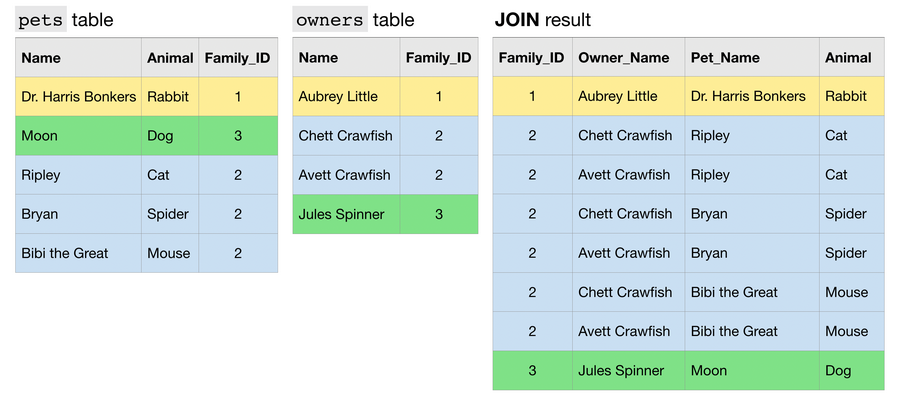

In [ ]:
big_join_query = """
                 SELECT repo,
                     COUNT(DISTINCT c.committer.name) as num_committers,
                     COUNT(DISTINCT f.id) AS num_files
                 FROM `bigquery-public-data.github_repos.commits` AS c,
                     UNNEST(c.repo_name) AS repo
                 INNER JOIN `bigquery-public-data.github_repos.files` AS f
                     ON f.repo_name = repo
                 WHERE f.repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                 GROUP BY repo
                 ORDER BY repo
                 """
show_time_to_run(big_join_query)

small_join_query = """
                   WITH commits AS
                   (
                   SELECT COUNT(DISTINCT committer.name) AS num_committers, repo
                   FROM `bigquery-public-data.github_repos.commits`,
                       UNNEST(repo_name) as repo
                   WHERE repo IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   ),
                   files AS 
                   (
                   SELECT COUNT(DISTINCT id) AS num_files, repo_name as repo
                   FROM `bigquery-public-data.github_repos.files`
                   WHERE repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   )
                   SELECT commits.repo, commits.num_committers, files.num_files
                   FROM commits 
                   INNER JOIN files
                       ON commits.repo = files.repo
                   ORDER BY repo
                   """

show_time_to_run(small_join_query)